In [1]:
import numpy as np

import matplotlib.pyplot as plt

from WDM.code.discrete_wavelet_transform.WDM import WDM_transform


# Wavelet transform (exact)

The forward discrete wavelet transform is defined

$$ w_{nm} = 2 \pi \delta t \sum_{k=0}^{N-1} g_{nm}[k] x[k] , $$

and transforms the input time-domain signal $x[k]$ ($k\in\{0,1,\ldots,N-1\}$)
into the time-frequency representation using the wavelet coefficients $w_{nm}$ 
($n\in\{0,1,\ldots,N_t-1\}$ and $m\in\{0,1,\ldots,N_f-1\}$)

The method `WDM_transform.forward_transform_exact` implements this transformation 
directly. 

WARNING: this method is slow but exact. The sum extends over the whole time-domain 
signal (i.e. no truncation in used) and time domain wavelets `g_{nm}[k]` are computed 
using inverse FFTs. The whole thing is implemented using for loops. 

The inverse discrete wavelet transform

$$ x[k] = \sum_{n=0}^{N_t-1} \sum_{m=0}^{N_f-1} w_{nm} g_{nm}[k] , $$

is implemented in a similar way in the method `WDM_transform.inverse_transform_exact`.

In [11]:
wdm = WDM_transform(dt=1., Nf=16, N=512, q=5)

x = np.random.normal(size=wdm.N) # white noise

w = wdm.forward_transform_exact(x)

x_recovered = wdm.inverse_transform_exact(w)

print(f"Check error is small: {np.abs(x-x_recovered).max()}")

Check error is small: 1.160249964771154e-06


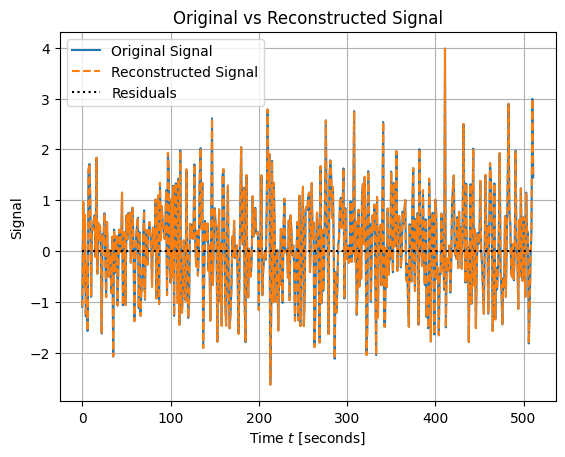

In [12]:
plt.plot(wdm.times, x, label='Original Signal')
plt.plot(wdm.times, x_recovered, label='Reconstructed Signal', linestyle='--')
plt.plot(wdm.times, x-x_recovered, label='Residuals', linestyle=':', c='k')

plt.xlabel('Time $t$ [seconds]')
plt.ylabel('Signal')
plt.title('Original vs Reconstructed Signal')
plt.legend()
plt.grid()
plt.show()

# Wavelet transform (truncated)

The time-domain wavelets $g_{nm}(t)$ are (approximately) localised in time. 
Therefore, it is not necessary to sum over the whole time series when computing the forward transfrom.

The parameter $q$ controls the truncation. Smaller values of $q$ will lead to a less accurate transfrom.

In [ ]:
N = 512

x = np.random.randn(N) # white noise

wdm = WDM_transform(dt=1., Nf=16, N=N, q=16)

w = wdm.forward_transform_exact(x)

W = wdm.forward_transform_truncated(x)


In [ ]:
err = np.abs(w-W)

row, col = np.unravel_index(np.argmax(err), err.shape)

row, col, w.shape

(np.int64(28), np.int64(0), (32, 16))

# Wavelet transform (fast)

# Demonstrate padding

In [ ]:
from WDM.code.utils.utils import next_multiple

x = np.random.randn(10) # white noise

Nf = 16

# pad to next even multiple of Nf
N = next_multiple(len(x), 2*Nf) 

x_padded, mask = wdm.pad_signal(x)

wdm = WDM_transform(dt=1., Nf=Nf, N=N)

print("Original signal length:", len(x))
print("Padded signal length:", len(x_padded))

# the mask can be used to recover the original signal
assert np.allclose(x,x_padded[mask]), "oops"


Original signal length: 10
Padded signal length: 512
